<img style="float: right;" src="imgs/kschool_logo.png">

# Taller de Machine Lerning Pipelines con Python
<p style='text-align: right;'>Beñat San Sebastián</p>

### Introducción

Los pipelines de machine learning se utilizan para automatizar los flujos de trabajo. Funcionan de tal manera que que se atomizan cada uno de los procesos de modo que la salida de uno de los pasos es consumida como entrada del siguiente paso. Un ejemplo de un pipeline clásico de Machine Learning sería el siguiente:

![Pipeline de Machine Learning](imgs/machine_learning_pipeline.png)

En este taller vamos a aprender, a través de une ejemplo, a utilizar los Pipelines de scikit-learn para el preprocesado, ingeniería de variables, entrenamiento y validación de nuestros modelos de machine learning.

Las principales ventajas de los pipelines son las siguientes: 

- El flujo de trabajo es mucho más fácil de leer y de entender
- Fácil utilización de transformadores públicos
- Fácil reutilización de transformadores propios
- Al tener el código atomizado es fácil hacer pruebas cambiando una pieza por otra
- Facilidad de productivización

A continucación importamos las librerías que vamos a utilizar:

In [41]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders import OrdinalEncoder, LeaveOneOutEncoder
import matplotlib.pyplot as plt
import joblib

### Nuestro ejemplo: Precio de venta de viviendas en Melbourne

Podéis descargar el dataset que usaremos en este enlace:
[https://www.kaggle.com/dansbecker/melbourne-housing-snapshot](https://www.kaggle.com/dansbecker/melbourne-housing-snapshot)

Las variables con las que vamos a trabajar son las siguientes:

- **Rooms:** Número de habitaciones
- **Type:** br - habitaciones; h - chalet,; u - unidad, duplex; t - adosado; dev site - en desarrollo; o res - otras
- **SellerG:** Agente Inmobiliario
- **Distance:** Distancia al centro de la ciudad
- **Regionname:** Nombre de la región
- **Propertycount:** Número de viviendas en el barrio
- **Bedroom2 :** Número de dormitorios (fuente distinta)
- **Bathroom:** Número de aseos
- **Car:** Plazas de aparcamiento
- **Landsize:** Superficie del terreno
- **BuildingArea:** Superficie de la vivienda
- **CouncilArea:** Junta de Gobierno del área
- **Price:** Precio en dólares (nuestra variable objetivo)

Procedemos a leer y visualizar el dataset:

In [42]:
df= pd.read_csv('data/melb_data.csv',
               usecols=[
                   'Suburb', 'Rooms', 'Type', 'SellerG',
                   'Distance', 'Postcode', 'Bedroom2', 'Bathroom', 
                   'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 
                   'CouncilArea', 'Lattitude', 'Longtitude', 'Regionname', 
                   'Propertycount','Price'
               ],
               dtype={
                   'Suburb':'str',
                   'Rooms':'int',
                   'Type':'str',
                   'SellerG':'str',
                   'Distance':'float',
                   'Postcode':'str',
                   'Bedroom2':'int',
                   'Bathroom':'int',
                   'Car':'float',
                   'Landsize':'float',
                   'BuildingArea':'float',
                   'YearBuilt':'float',
                   'CouncilArea':'str',
                   'Lattitude':'float',
                   'Longtitude':'float',
                   'Regionname':'str',
                   'Propertycount':'str'
               })
df.head()

,Suburb,Rooms,Type,Price,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,2,h,1480000.0,Biggin,2.5,3067.0,2,1,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,2,h,1035000.0,Biggin,2.5,3067.0,2,1,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,3,h,1465000.0,Biggin,2.5,3067.0,3,2,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,3,h,850000.0,Biggin,2.5,3067.0,3,2,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,4,h,1600000.0,Nelson,2.5,3067.0,3,1,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


Descripción de las variables numéricas:

In [43]:
df.describe()

,Rooms,Price,Distance,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,Lattitude,Longtitude
count,13580.000000,1.358000e+04,13580.000000,13580.000000,13580.000000,13518.000000,13580.000000,7130.000000,8205.000000,13580.000000,13580.000000
mean,2.937997,1.075684e+06,10.137776,2.914728,1.534242,1.610075,558.416127,151.967650,1964.684217,-37.809203,144.995216
std,0.955748,6.393107e+05,5.868725,0.965921,0.691712,0.962634,3990.669241,541.014538,37.273762,0.079260,0.103916
min,1.000000,8.500000e+04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1196.000000,-38.182550,144.431810
25%,2.000000,6.500000e+05,6.100000,2.000000,1.000000,1.000000,177.000000,93.000000,1940.000000,-37.856822,144.929600
50%,3.000000,9.030000e+05,9.200000,3.000000,1.000000,2.000000,440.000000,126.000000,1970.000000,-37.802355,145.000100
75%,3.000000,1.330000e+06,13.000000,3.000000,2.000000,2.000000,651.000000,174.000000,1999.000000,-37.756400,145.058305
max,10.000000,9.000000e+06,48.100000,20.000000,8.000000,10.000000,433014.000000,44515.000000,2018.000000,-37.408530,145.526350


Observamos que existen valores nulos en algunas variables:

In [44]:
df.isnull().any()

Suburb           False
Rooms            False
Type             False
Price            False
SellerG          False
Distance         False
Postcode         False
Bedroom2         False
Bathroom         False
Car               True
Landsize         False
BuildingArea      True
YearBuilt         True
CouncilArea       True
Lattitude        False
Longtitude       False
Regionname       False
Propertycount    False
dtype: bool

Dividimos el dataset en Train (80%) y Test (20%) cogiendo como variable objetivo (`y`) el precio (`Price`):

In [45]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('Price', axis=1), 
                                                    df['Price'], 
                                                    test_size=0.2,
                                                    random_state=707)

Creamos listados de las columnas numéricas y categóricas que nos resultarán útiles a la hora de realizar el preprocesado:

In [46]:
numeric_cols = ['Rooms', 'Distance', 'Bedroom2', 'Bathroom', 
                'Car', 'Landsize', 'BuildingArea', 'YearBuilt', 
                'Lattitude', 'Longtitude', 'Propertycount']
categoric_cols = ['Suburb', 'Type', 'SellerG', 'Postcode', 
                  'CouncilArea','Regionname',]

### Iteración 1: Nuestro primer Pipeline

A continuación vamos a crear nuestro primer pipeline. En esta primera aproximación **sólo utilizaremos las variables numéricas**.

![Primer Pipeline](imgs/primer_pipeline.png)

Para crear nuestros pipeline primero definimos cada uno de los objetos del mismo:
1. Imputar nulos mediante `SimpleImputer`
2. Reescalar los datos con `StandardScaler`
3. Regresión lineal mediante `LinearRegression`

In [7]:
num_imputer = SimpleImputer(strategy='median')
scaler = StandardScaler()
lr = LinearRegression()

Creamos una lista de tuplas en las que cada tupla corresponde a un par de `('nombre del paso', objeto)`.

In [8]:
steps = [
    ('numeric_imputer', num_imputer),
    ('scaler', scaler),
    ('regressor', lr)
]

Para crear el pipeline sólo tenemos que utilizar `Pipeline` de scikit-learn y pasarle la lista de tuplas:

In [9]:
pipeline_first = Pipeline(steps)

#### ¿Cómo podemos utilizar los pipelines?
##### transform
Cuando utilizamos el método `transform` en el pipeline es como si hiciemos `transform` uno a uno en cada uno de los objetos:
![transform](imgs/transform.png)

In [47]:
pipeline_first.transform(X_train[numeric_cols], y_train)

AttributeError: 'LinearRegression' object has no attribute 'transform'

Nos da error porque el regresor (el último paso) no tiene método `transform`.

Estos son otros métodos del pipeline:
##### fit_transform
Cuando utilizamos el método `fit_transform` en el pipeline es como si hiciemos `fit_transform` uno a uno en cada uno de los objetos (o primero `fit` seguido de `transform` si el objeto no tiene ese método):
![fit_transform](imgs/fit_transform.png)

##### fit
Cuando utilizamos el método `fit` en el pipeline es como si hiciemos `fit_transform` (o primero `fit` seguido de `transform` si el objeto no tiene ese método) uno a uno en cada uno de los objetos hasta llegar al último donde hace un `fit`:
![fit](imgs/fit.png)

##### predict
Cuando utilizamos el método `predict` (funciona de la misma manera con `predict_proba`) en el pipeline es como si hiciemos `transform` uno a uno en cada uno de los objetos hasta llegar al último donde hace un `predict`.:
![predict](imgs/predict.png)

Vamos a probar a entrenar nuestro pipeline:

In [48]:
pipeline_first.fit(X_train[numeric_cols], y_train)

Pipeline(steps=[('numeric_imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('regressor', LinearRegression())])

Realizamos una predicción del dataset de train y calculamos la raíz del error cuadrático medio que será nuestra métrica en este workshop:

In [49]:
y_train_pred = pipeline_first.predict(X_train[numeric_cols])
mean_squared_error(y_train, y_train_pred, squared=False)

442318.51141938695

Podemos acceder a un objeto particular del pipeline indexándolo por el nombre que le hemos dado:

In [13]:
pipeline_first['regressor']

LinearRegression()

O por su posición utilizando `steps`:

In [14]:
pipeline_first.steps[0]

('numeric_imputer', SimpleImputer(strategy='median'))

En este caso hemos accedido a la tupla, para poder apuntar al objeto tenemos que quedarnos con el objeto que está en la posición `1`:

In [15]:
pipeline_first.steps[0][1]

SimpleImputer(strategy='median')

Si queremos cambiar el regresor sólo tenemos que volver a crear el Pipeline cambiando el paso del regresor. Como se puede ver sería muy fácil iterar con distintos regresores para poder evaluarlos:

In [50]:
rf = RandomForestRegressor()

steps = [
    ('numeric_imputer', num_imputer),
    ('scaler', scaler),
    ('regressor', rf)
]

pipeline_second = Pipeline(steps)
pipeline_second.fit(X_train[numeric_cols], y_train)

y_train_pred = pipeline_second.predict(X_train[numeric_cols])
mean_squared_error(y_train, y_train_pred, squared=False)

113888.87536116286

### Iteración 2: Pipeline sencillo utilizando FunctionTransformer y validación cruzada

El anterior pipeline sólo podía operar con variables numéricas. Vamos a añadirle un paso previo para que seleccione las variables numéricas y así poder utilizarlo con el dataste completo.

Nuestro pipeline quedaría así:

![Pipeline Sencillo](imgs/pipeline_sencillo.png)

#### Definimos una función para seleccionar variables
Para crear nuestro selector de variables numéricas vamos a crear una función que dado un dataframe devuelve sólo las variables de tipo `int` y `float`:


In [17]:
def select_numeric(df):
    return df.select_dtypes(include=['int', 'float'])

#### FunctionTransformer

Para convertir esta función en un transformador compatible con los pipelines de scikit-learn es tan sencillo como utilizar `FunctionTransformer`:

In [18]:
sel_numeric = FunctionTransformer(select_numeric)

Creamos el pipeline tal y como hemos hecho antes:

In [19]:
steps = [
    ('select_numeric', sel_numeric),
    ('numeric_imputer', num_imputer),
    ('scaler', scaler),
    ('regressor', rf)
]
pipeline_easy = Pipeline(steps)

Como no tenemos muchos datos vamos a utilizar una búsqueda de hiperparámetros aleatoria con validación cruzada. Es tan sencillo como utilizar nuestro pipeline como estimador del `RandomizedSearchCV`. Para definir la parrilla de hiperparámetros pondremos primero el nombre del paso del pipeline (`regressor`), seguido de doble barra baja (`__`) y seguido del nombre del parámetro (`max_depth`):

In [20]:
param_grid = {
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}

rscv = RandomizedSearchCV(pipeline_easy, 
                          cv=5, 
                          n_iter=10, 
                          n_jobs=10, 
                          param_distributions=param_grid, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)

rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('select_numeric',
                                              FunctionTransformer(func=<function select_numeric at 0x7f511cbcf0d0>)),
                                             ('numeric_imputer',
                                              SimpleImputer(strategy='median')),
                                             ('scaler', StandardScaler()),
                                             ('regressor',
                                              RandomForestRegressor())]),
                   n_jobs=10,
                   param_distributions={'regressor__bootstrap': [True],
                                        'regressor__max_depth': [80, 90, 100,
                                                                 110],
                                        'regressor__max_features': [2, 3],
                                        'regressor__min_samples_leaf': [3, 4,
                                   

In [21]:
-rscv.best_score_

304020.65871237044

### Iteración 3: Anidando pipelines

Vamos a incluir las variables categóricas a nuestro modelo. Para ello:
1. Vamos crear un pipeline de dos pasos para el **preprocesado de las variables numéricas** (imputación de nulos y reescalado).
2. Vamos a crer un **encoder ordinal para las variables categóricas** mediante `OrdinalEncoder`. Como incluye funcionalidad para tratamiento de nulos no necesitamos más pasos.
3. Vamos a juntar ambos procesos mediante `ColumnTransformer`.

![Pipeline Medio](imgs/pipeline_medio.png)

#### ColumnTransformer
Se define de forma similar a los pipelines. Tenemos que dar una tupla de tres con `('nombre del paso', objeto, lista de columnas)`

In [22]:
pipeline_num = Pipeline([('numeric_imputer', num_imputer), ('scaler', scaler)])
encoder = OrdinalEncoder()
preprocessing = ColumnTransformer([('numeric_prep', pipeline_num, numeric_cols),
                                   ('categoric_prep', encoder, categoric_cols)])

Finalmente creamos un pipeline con el preprocesado que hemos definido anteriormente y nuestro regresor:

In [23]:
pipeline_medium = Pipeline([('preprocessing', preprocessing), ('regressor', rf)])

Entrenamos con busqueda de hiperparámetros y validación cruzada:

In [24]:
rscv = RandomizedSearchCV(pipeline_medium, 
                          cv=5, 
                          n_iter=10, 
                          n_jobs=10, 
                          param_distributions=param_grid, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric_prep',
                                                                               Pipeline(steps=[('numeric_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Rooms',
                                                                                'Distance',
                                                                                'Bedroom2',
                                                                           

In [25]:
-rscv.best_score_

297359.3367270838

### Iteración 4: Pipeline Avanzado con Target Encoding

Vamos a añadir un encoder más complejo para aquellas variables categóricas de dimensionalidad alta. Para ello vamos a utilizar una variante de 'target encoder' llámada `LeaveOneOutEncoder`. Este tipo de encoders son muy potentes porque utilizan la variable objetivo para codificar las variables categoricas capturando así posibles correlaciones que puedab existir con el target. Sin embargo, tienen un riesgo muy alto de sobreajustar, ya que se ha utilizado la información del target en el proceso. No es objeto de este taller, pero quien esté más intersado puede obtener más información sobre 'target encoding' aquí: [https://brendanhasz.github.io/2019/03/04/target-encoding](https://brendanhasz.github.io/2019/03/04/target-encoding) 

**Nota friki:** Target Encoding se utiliza mucho en las competiciones de Kaggle.

Nuestro pipeline quedaría tal que así:

![Pipeline Avanzado](imgs/pipeline_avanzado.png)

In [26]:
target_encoder = LeaveOneOutEncoder()
preprocessing = ColumnTransformer([('numeric_prep', pipeline_num, numeric_cols),
                                   ('ordindal_encoder', encoder, ['Type', 'CouncilArea', 'Regionname']),
                                   ('target_encoder', target_encoder, ['Suburb', 'SellerG', 'Postcode'])])
pipeline_advanced = Pipeline([('preprocessing', preprocessing), ('regressor', rf)])

El target encoder tiene sus propios hiperparámetros de regularización para evitar el sobreajuste.

#### ¿Cómo sabemos que valor es el correcto?

Aquí empezamos a ver el verdadero valor de los pipelines de scikit-learn. Como vamos a todo el proceso por validación cruzada, podemos hacer una búsqueda de los hiperparámetros de los transformadores de la misma manera que lo hacemos habitualmente con los estimadores.

Si hubiese realizado el encoding sin utilizar pipelines, antes de aplicar validación cruzada estaría podría 'comer' todo el overfitting en el proceso de validación y llevarme una sorpresa desagradable al realizar el test.


![Cross Validation](imgs/cross_validation_EN.png)
<p style='text-align: right;'>source: Wikipedia</p>


Podemos incluir el parámetro `sigma` de `LeaveOneOutEncoder` en la parrilla anidando barras bajas dobles (tenemos que bajar dos niveles):
`preprocessing__target_encoder__sigma`.

In [27]:
params = {
    'preprocessing__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}

rscv = RandomizedSearchCV(pipeline_advanced, 
                          cv=5, 
                          n_iter=20, 
                          n_jobs=10, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric_prep',
                                                                               Pipeline(steps=[('numeric_imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['Rooms',
                                                                                'Distance',
                                                                                'Bedroom2',
                                                                           

In [28]:
rscv.best_params_

{'regressor__n_estimators': 1000,
 'regressor__min_samples_split': 8,
 'regressor__min_samples_leaf': 3,
 'regressor__max_features': 3,
 'regressor__max_depth': 80,
 'regressor__bootstrap': True,
 'preprocessing__target_encoder__sigma': 0.02}

In [29]:
-rscv.best_score_

293520.1999275821

### Iteración 5: Pipeline Avanzado con Transformadores Propios - BONUS

Podemos incluir nuestros propios transformadores en los pipelines. Para ello tenemos que definir una clase con los métodos `fit` y `transform`. Si utilizamos `BaseEstimator` de sckit-learn la añadira los métodos para añadir y extraer parámetros. Si utilizamos `TransformerMixin` le añadirá el método `fit_transform` de manera automática.

Vamos a realizar un cluster espacial para añadir la misma etiqueta a aquellas viviendas que se encuentran cerca. Esto puede aportarnos un valor más objetivo que los barrios en los que están las viviendas.

Definimos la clase utilizando KMeans:

In [30]:
class KMeansLatLon(BaseEstimator, TransformerMixin):
    def __init__(self, columns, n_clusters=10):
        self.columns = columns
        self.n_clusters = n_clusters
        self.model = KMeans(n_clusters=self.n_clusters)

    def fit(self, X, y=None):
        self.model.fit(X[self.columns])
        return self

    def transform(self, X, y=None):
        data = X.copy()
        pred = self.model.predict(data[self.columns])
        data['LatLonCluster'] = pred
        return data 

Veamos como funciona esta clase:

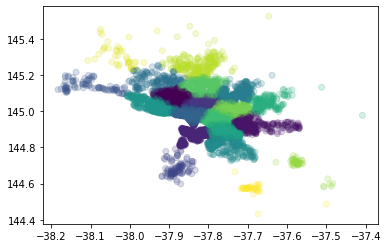

In [31]:
example_cluster = KMeansLatLon(['Lattitude', 'Longtitude'], n_clusters=20)
X_train_cluster = example_cluster.fit_transform(X_train)
plt.scatter(X_train_cluster['Lattitude'],
            X_train_cluster['Longtitude'],
            c = X_train_cluster['LatLonCluster'],
            alpha = 0.2)

In [32]:
X_train_cluster.head()

,Suburb,Rooms,Type,SellerG,Distance,Postcode,Bedroom2,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount,LatLonCluster
12267,Croydon,4,h,Fletchers,23.0,3136.0,4,2,2.0,655.0,184.0,1965.0,NaN,-37.79725,145.29651,Eastern Metropolitan,11925.0,17
7251,West Footscray,3,h,Sweeney,8.2,3012.0,3,1,2.0,434.0,NaN,NaN,Maribyrnong,-37.79080,144.87930,Western Metropolitan,5058.0,11
2309,Elwood,1,u,Chisholm,7.7,3184.0,1,1,1.0,0.0,NaN,1970.0,Port Phillip,-37.88950,144.99020,Southern Metropolitan,8989.0,6
623,Balwyn North,4,h,Marshall,9.2,3104.0,4,3,2.0,1070.0,247.0,1992.0,Boroondara,-37.79750,145.07160,Southern Metropolitan,7809.0,3
12658,Box Hill,3,h,Lindellas,10.9,3128.0,3,1,2.0,667.0,NaN,NaN,NaN,-37.82132,145.12891,Eastern Metropolitan,4605.0,14


#### Pipeline con Custom Transformer

Nuestro pipeline quedaría así:

![Pipeline con Custom Transformer](imgs/pipeline_custom_transformer.png)

Definimos un nuevo pipeline de preprocesado de numéricas (he quitado el reesaclado porque como estamos utilizando árboles no nos hace falta reescalarlo):

In [33]:
geospatial_cluster = KMeansLatLon(['Lattitude', 'Longtitude'])
pipeline_num = Pipeline([('geoespatial_cluster', geospatial_cluster), 
                         ('numeric_imputer', num_imputer)])

Juntamos los preprocesados con `ColumnTransformer`:

In [34]:
preprocessing = ColumnTransformer([('numeric_prep', pipeline_num, numeric_cols),
                                   ('ordindal_encoder', encoder, ['Type', 'CouncilArea', 'Regionname']),
                                   ('target_encoder', target_encoder, ['Suburb', 'SellerG', 'Postcode'])])

Creamos el pipeline:

In [35]:
pipeline_with_clusters = Pipeline([('preprocessing', preprocessing), ('regressor', rf)])

Preparamos nuestra parrilla incluyendo el número de clusters como hiperparámetro y entrenamos:

In [36]:
params = {
    'preprocessing__numeric_prep__geoespatial_cluster__n_clusters': [5, 10, 20],
    'preprocessing__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'regressor__bootstrap': [True],
    'regressor__max_depth': [80, 90, 100, 110],
    'regressor__max_features': [2, 3],
    'regressor__min_samples_leaf': [3, 4, 5],
    'regressor__min_samples_split': [8, 10, 12],
    'regressor__n_estimators': [100, 200, 300, 1000]
}

rscv = RandomizedSearchCV(pipeline_with_clusters, 
                          cv=5, 
                          n_iter=5, 
                          n_jobs=20, 
                          param_distributions=params, 
                          scoring='neg_root_mean_squared_error',
                          random_state=707)
rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessing',
                                              ColumnTransformer(transformers=[('numeric_prep',
                                                                               Pipeline(steps=[('geoespatial_cluster',
                                                                                                KMeansLatLon(columns=['Lattitude',
                                                                                                                      'Longtitude'])),
                                                                                               ('numeric_imputer',
                                                                                                SimpleImputer(strategy='median'))]),
                                                                               ['Rooms',
                                                                                'Distance',
   

In [37]:
rscv.best_params_

{'regressor__n_estimators': 1000,
 'regressor__min_samples_split': 10,
 'regressor__min_samples_leaf': 5,
 'regressor__max_features': 3,
 'regressor__max_depth': 110,
 'regressor__bootstrap': True,
 'preprocessing__target_encoder__sigma': 0.03,
 'preprocessing__numeric_prep__geoespatial_cluster__n_clusters': 5}

In [38]:
-rscv.best_score_

297793.6175159855

### Test 

Vemos nuestro resultado en test:

In [39]:
y_pred = rscv.predict(X_test)
mean_squared_error(y_test, y_pred, squared=False)

285339.06721463474

### Productivización 

Dado que el pipeline incluye tanto el preprocesado como el estimador, al guardar este conseguimos encapsular en un sólo fichero todo el proceso. Esto facilita muchísimo la puesta en producción posterior de los modelos (sea medaiante API o meadiante proceso batch) porque bastaría con cargar el 'pikle' que hemos generado, en lugar de ir adaptando todo el código al entorno productivo:

In [40]:
joblib.dump(rscv.best_estimator_, 'model/trained_pipeline.pkl')

['model/trained_pipeline.pkl']

### Conclusiones

Los pipelines son útiles para los Data Scientist porque:
- El trabajo es mucho más fácil de leer y reproducir. Tu yo del futuro lo agradecerá cuando tenga que revisitar el código.
- La fácil reutilización de herramientas propias o agenas ahorra trabajo a largo plazo. Tu yo del futuro lo agradecerá cuando tenga que iniciar un nuevo proyecto.
- Es fácil de productivizar. Tu yo del futuro lo agradecerá cuando tenga que poner el modelo en producción.

### ¡Muchas Gracias por Vuestra Atención!

Si tenéis cualquier duda, consulta o sugerencia estaré encantado de responder.

GitHub: https://github.com/bsanse/dk_pipelines_workshop

Email: bsanse@gmail.com

Linkedin: https://www.linkedin.com/in/bsanse/